In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in*



loss: 0.000000
sanity check: 2.302585
numerical: 1.864366 analytic: 1.864366, relative error: 1.091112e-10
numerical: -0.289799 analytic: -0.289799, relative error: 4.847023e-09
numerical: -1.502692 analytic: -1.502692, relative error: 3.675042e-10
numerical: -0.924676 analytic: -0.924676, relative error: 1.169383e-09
numerical: 0.639126 analytic: 0.639126, relative error: 3.573420e-09
numerical: -0.787469 analytic: -0.787469, relative error: 2.795682e-09
numerical: -0.281263 analytic: -0.281263, relative error: 1.018733e-08
numerical: 1.272888 analytic: 1.272888, relative error: 1.441340e-09
numerical: -1.032656 analytic: -1.032656, relative error: 1.917009e-09
numerical: -9.267289 analytic: -9.267289, relative error: 7.976661e-11
numerical: -2.609780 analytic: -2.609780, relative error: 1.133844e-09
numerical: 1.356714 analytic: 1.356714, relative error: 1.388851e-09
numerical: -2.282893 analytic: -2.282893, relative error: 1.845666e-09
numerical: -1.507739 analytic: -1.507739, relat

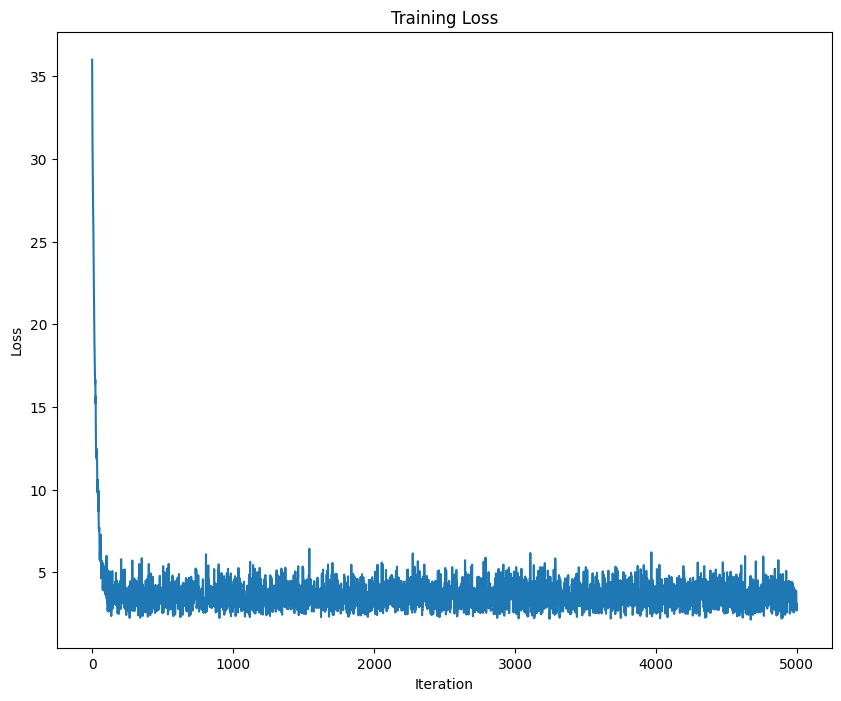

lr 1.000000e-07 reg 5.000000e+02 train accuracy: 0.320857 val accuracy: 0.332000
lr 1.000000e-07 reg 7.500000e+02 train accuracy: 0.322143 val accuracy: 0.321000
lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.334755 val accuracy: 0.320000
lr 1.000000e-07 reg 1.250000e+03 train accuracy: 0.341653 val accuracy: 0.346000
lr 1.000000e-07 reg 1.500000e+03 train accuracy: 0.330122 val accuracy: 0.326000
lr 1.000000e-07 reg 2.000000e+03 train accuracy: 0.359000 val accuracy: 0.358000
lr 5.000000e-07 reg 5.000000e+02 train accuracy: 0.413245 val accuracy: 0.405000
lr 5.000000e-07 reg 7.500000e+02 train accuracy: 0.415265 val accuracy: 0.411000
lr 5.000000e-07 reg 1.000000e+03 train accuracy: 0.415531 val accuracy: 0.414000
lr 5.000000e-07 reg 1.250000e+03 train accuracy: 0.239959 val accuracy: 0.232000
lr 5.000000e-07 reg 1.500000e+03 train accuracy: 0.407837 val accuracy: 0.397000
lr 5.000000e-07 reg 2.000000e+03 train accuracy: 0.403367 val accuracy: 0.412000
lr 1.000000e-06 reg 5.000000

In [ ]:
from cs231n.classifiers.softmax import softmax_loss_naive
from cs231n.classifiers.linear_classifier import LinearClassifier
import time
import numpy as np
import matplotlib.pyplot as plt

W = np.random.randn(X_train.shape[1], 10) * np.sqrt(2.0 / X_train.shape[1])
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
def softmax_loss_naive(W, X, y, reg):
    loss = 0.0
    dW = np.zeros_like(W)
    num_classes = W.shape[1]
    num_train = X.shape[0]

    for i in range(num_train):
        scores = X[i].dot(W)
        scores -= np.max(scores)
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores)

        loss -= np.log(probs[y[i]])

        for j in range(num_classes):
            dW[:, j] += X[i] * probs[j]
            if j == y[i]:
                dW[:, j] -= X[i]

    loss /= num_train
    dW /= num_train

    loss += 0.5 * reg * np.sum(W * W)
    dW += reg * W

    return loss, dW

loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
def softmax_loss_vectorized(W, X, y, reg):
    num_classes = W.shape[1]
    num_train = X.shape[0]

    scores = X.dot(W)
    scores -= np.max(scores, axis=1, keepdims=True)
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    correct_logprobs = -np.log(probs[range(num_train), y])
    loss = np.sum(correct_logprobs) / num_train + 0.5 * reg * np.sum(W * W)

    dscores = probs
    dscores[range(num_train), y] -= 1
    dscores /= num_train

    dW = X.T.dot(dscores)
    dW += reg * W

    return loss, dW

tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

class Softmax(LinearClassifier):
    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        num_train, dim = X.shape
        num_classes = np.max(y) + 1

        if self.W is None:

            self.W = 0.001 * np.random.randn(dim, num_classes)

        loss_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None

            indices = np.random.choice(num_train, batch_size, replace=False)
            X_batch = X[indices]
            y_batch = y[indices]

            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            self.W -= learning_rate * grad

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            if it > 5 and np.abs(loss_history[-1] - loss_history[-2]) < 1e-5:
                print('Early stopping at iteration', it)
                break

        return loss_history

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        scores = X.dot(self.W)
        y_pred = np.argmax(scores, axis=1)
        return y_pred

learning_rates = [1e-7, 5e-7, 1e-6, 2e-6, 5e-6, 1e-5]
regularization_strengths = [500, 750, 1000, 1250, 1500, 2000]

results = {}
best_val = -1
best_softmax = None
best_params = None

num_iters = 5000
batch_size = 200

for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        loss_history = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                                     num_iters=num_iters, batch_size=batch_size,
                                     verbose=False)

        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)

        results[(lr, reg)] = (train_accuracy, val_accuracy)

        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax
            best_params = (lr, reg)

        print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
              lr, reg, train_accuracy, val_accuracy))

plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)
print('best params:', best_params)

y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



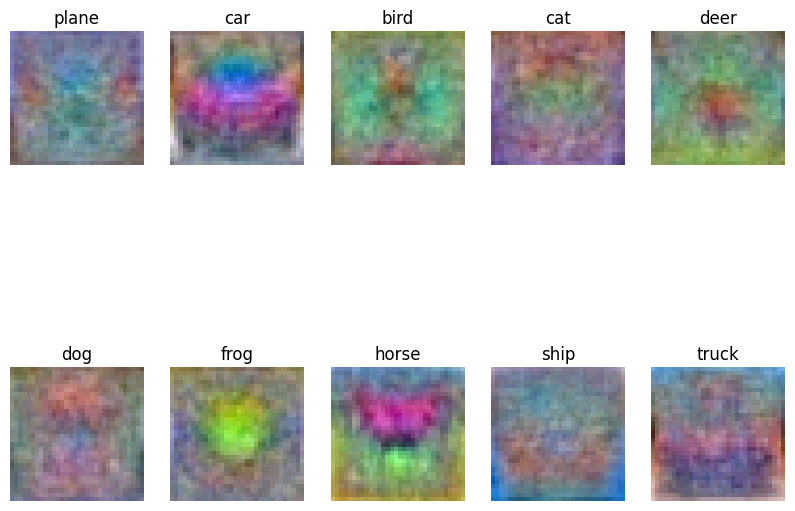

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])